<a href="https://colab.research.google.com/github/justlab11/MLTSA22_JLabombard/blob/main/HW9/HW9_JLabombard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports
---

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
from google.colab import drive
import pylab as pl
import seaborn as sns

import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras import optimizers
from tensorflow import keras

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
drive.mount('/content/drive', force_remount=True) # this is because my drive is refusing to update

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/MLTSA22/HW8

/content/drive/MyDrive/MLTSA22/HW8


## Getting and Reshaping Data
---
* I exported the array as the wrong shape in homework 8. Luckily, I just had to do a minor reshape to correct this issue. 

In [4]:
data_lin = np.load("lin_ipl.npy")

In [5]:
lin2d = np.reshape(data_lin, (-1,600))

In [6]:
lin2d.shape

(7848, 600)

## Model
---
* This model is a simple model with a bottleneck layer in the middle (shrinks to 50)

In [7]:
X_train = lin2d

In [8]:
ndim = X_train.shape[1]
# define model
autoencoder = Sequential()

autoencoder.add(Dense(100, activation="relu", input_dim=ndim))
autoencoder.add(Dense(50, activation="relu"))
autoencoder.add(Dense(100, activation="relu"))
autoencoder.add(Dense(ndim, activation="linear"))

In [9]:
opt = keras.optimizers.Adam(learning_rate=1e-4)
autoencoder.compile(optimizer=opt, loss="mean_squared_error")

print(autoencoder.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               60100     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dense_3 (Dense)             (None, 600)               60600     
                                                                 
Total params: 130,850
Trainable params: 130,850
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
encoder_hist = autoencoder.fit(X_train, X_train,
                               validation_split=0.2,
                               epochs=500, batch_size=100, verbose=1)

Epoch 1/500
63/63 [==============================] - 2s 16ms/step - loss: 6571923.5000 - val_loss: 87888688.0000
Epoch 2/500
63/63 [==============================] - 1s 9ms/step - loss: 6400573.5000 - val_loss: 87337944.0000
Epoch 3/500
63/63 [==============================] - 1s 8ms/step - loss: 6319083.0000 - val_loss: 86867976.0000
Epoch 4/500
63/63 [==============================] - 1s 10ms/step - loss: 6193472.5000 - val_loss: 86697848.0000
Epoch 5/500
63/63 [==============================] - 1s 9ms/step - loss: 5986080.0000 - val_loss: 86509616.0000
Epoch 6/500
63/63 [==============================] - 1s 10ms/step - loss: 5646918.5000 - val_loss: 86177608.0000
Epoch 7/500
63/63 [==============================] - 1s 11ms/step - loss: 5163413.0000 - val_loss: 85813096.0000
Epoch 8/500
63/63 [==============================] - 1s 8ms/step - loss: 4602792.0000 - val_loss: 85420496.0000
Epoch 9/500
63/63 [==============================] - 1s 10ms/step - loss: 4399219.5000 - val_loss: 8

Text(0.5, 0, 'iteration')

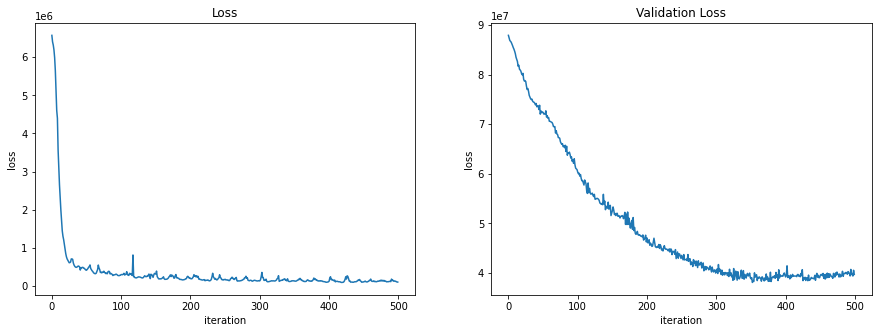

In [11]:
fig, (ax1, ax2) = pl.subplots(1,2,sharex=True, figsize=(15,5))

ax1.plot(np.array(encoder_hist.history['loss']))
ax1.set_title("Loss")
ax1.set_ylabel('loss')
ax1.set_xlabel('iteration')

ax2.plot(np.array(encoder_hist.history['val_loss']))
ax2.set_title("Validation Loss")
ax2.set_ylabel('loss')
ax2.set_xlabel('iteration')


Figure 1: Loss and validation loss of the model. The loss has a massive decrease at first then converses at ~120,000. The validation loss is a bit stranger, it hits a bit of a snag in the middle and then continues downward

## Testing and Predicting
---
* This section will display plots of the model predicting different objects. 

In [12]:
preds = autoencoder.predict(X_train)

In [13]:
preds.shape

(7848, 600)

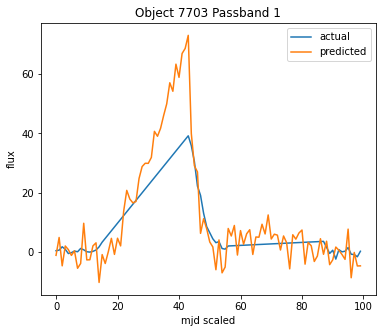

In [14]:
pl.figure(figsize=(6,5))
pl.plot(X_train[41,100:200]);
pl.xlabel("mjd scaled");
pl.ylabel("flux")
pl.title("Object 7703 Passband 1");

pl.plot(preds[41,100:200]);

pl.legend(["actual","predicted"]);

Figure 2: Actual plot vs the predicted plot for object 7703, passband 1. While the predicted goes much higher than the actual, it follows a similar trend to the original data. Both plots increase and decrease at the same time as seen at mjd scaled=20 and mjd scaled=45. The model struggles to predict during gaps in the data.

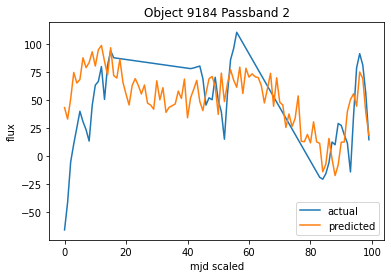

In [15]:
pl.plot(X_train[49,200:300], label="Raw Data");
pl.plot(preds[49,200:300], label="Preds");
pl.xlabel("mjd scaled");
pl.ylabel("flux")
pl.title("Object 9184 Passband 2");

pl.legend(["actual","predicted"]);

Figure 3: Another plot of the actual and predicted values for an object. The predicted follows the shape of the actual. It has similar peaks and valleys, but it is more rigid.

## Comparison of Random Forest Classifiers
---
* I will use random forest classifiers fit to two different pieces of data and analyze the results.
* The data will go as follows:
  * alldata_rf - a random forest trained on the features from HW7 and the new features from HW8.
  * feature_rf - a random forest trained on _only_ the feature data from Hw7.

In [16]:
compressed_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
compressed_output = compressed_model.predict(X_train)
compressed_output.shape

(7848, 50)

In [17]:
feature_data = pd.read_csv("/content/drive/MyDrive/MLTSA22/HW7/features.csv")
metadata = pd.read_csv("/content/drive/MyDrive/MLTSA22/HW8/training_set_metadata.csv")

In [18]:
feature_data["target"] = metadata.target

In [19]:
col_names = [f"compress_{i}" for i in range(0, 50)]
comp_df = pd.DataFrame(compressed_output, columns=col_names)

In [20]:
X = feature_data.drop(columns=["target","object_id"]).merge(
    comp_df, left_index=True, right_index=True)
y = feature_data.target

alldata_rf = RandomForestClassifier(max_depth=8, random_state=1456)

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
alldata_rf.fit(X_train, y_train)
alldata_rf_score = alldata_rf.score(X_test, y_test)

print(alldata_rf_score)

0.6089171974522293


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


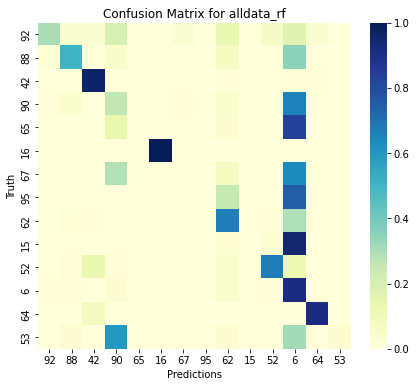

In [21]:
y_pred_test = alldata_rf.predict(X_test)
matrix = confusion_matrix(y_test, y_pred_test)
matrix = pd.DataFrame(matrix, columns=y.unique(), index=y.unique())
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis];
# matrix = (matrix / matrix.sum(axis=0)).fillna(0)

pl.figure(figsize=(7,6));

sns.heatmap(matrix, cmap="YlGnBu");
pl.ylabel("Truth");
pl.xlabel("Predictions");
pl.title("Confusion Matrix for alldata_rf");

Figure 4: The normalized confusion matrix for alldata_rf. The random forest does a pretty solid job predicting some of the targets. In this plot, the darker colors mean that there are a larger proportion of classifications for that particular class. The model overpredicts 6 a lot, and succeeds at predicting targets 42, 16, 6, and 64.

In [22]:
X = feature_data.drop(columns=["target","object_id"])
y = feature_data.target

feature_rf = RandomForestClassifier(max_depth=8, random_state=1456)

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
feature_rf.fit(X_train, y_train)
feature_rf_score = feature_rf.score(X_test, y_test)

print(feature_rf_score)

0.619108280254777


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


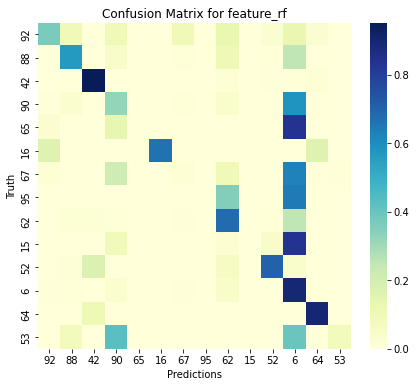

In [23]:
y_pred_test = feature_rf.predict(X_test)
matrix = confusion_matrix(y_test, y_pred_test)
matrix = pd.DataFrame(matrix, columns=y.unique(), index=y.unique())
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis];

pl.figure(figsize=(7,6))
sns.heatmap(matrix, cmap="YlGnBu");
pl.ylabel("Truth")
pl.xlabel("Predictions")
pl.title("Confusion Matrix for feature_rf");

Figure 5: The normalized confusion matrix for feature_rf. Again, it does a similarly good job at classifying the same targets as in Figure 4. This model also overpredicts target 6 a lot. 

In [24]:
print(f"Accuracy for alldata_rf: {alldata_rf_score}")
print(f"Accuracy for feature_rf: {feature_rf_score}")

Accuracy for alldata_rf: 0.6089171974522293
Accuracy for feature_rf: 0.619108280254777


The accuracies for both random forests are pretty close, with a small difference of ~.011 or 1.1%. Even with the extra data, there is not major change in accuracy. Most of the information lies in the feature data we captured from HW7 and not from HW8.